In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re

In [2]:
filename_train = 'data/train.csv'
filename_test = 'data/test.csv'

df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

In [3]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
import seaborn as sns

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


<AxesSubplot:>

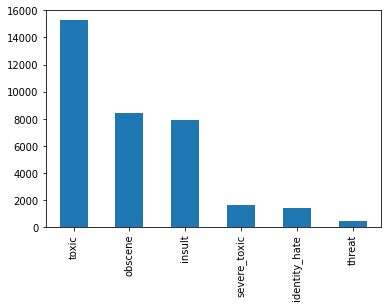

In [6]:
melted_class = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum()
melted_class = melted_class.sort_values(ascending=False)
print(melted_class)
melted_class.plot(kind='bar')

In [7]:
train = df_train[['comment_text','toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [8]:
# train_1 = train[train['toxic'] == 1]
# train_0 = train[train['toxic'] == 0].sample(n=train['toxic'].sum())

# train = pd.concat([train_1, train_0])
# train = train.sample(frac=1)
# train.head()

In [9]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

def remove_symbols(sentence) :
    return re.sub(r'[^\w]', ' ', sentence)

In [10]:
train["text_no_stopwords"] = train["comment_text"].apply(lambda x : remove_stopwords(x))
train["text_final"] = train["text_no_stopwords"].apply(lambda x : remove_symbols(x))
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_no_stopwords,text_final
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! matches background colour seemingly stu...,d aww matches background colour seemingly stu...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, really not trying edit war. just guy ...",hey man really not trying edit war just guy ...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" can't make real suggestions improvement - wo...",can t make real suggestions improvement wo...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, hero. chance remember page on?",you sir hero chance remember page on


In [11]:
def train_val_split(data, split) :
    train = []
    train_label = []
    validation = []
    val_label = []
    for ind,val in data.iterrows() :
        if len(train) < len(data)*split :
            train.append(val['text_final'])
            train_label.append(np.array(val[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values))
        else :
            validation.append(val['text_final'])
            val_label.append(np.array(val[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values))
    
    train = np.array(train)
    train_label = np.array(train_label)
    validation = np.array(validation)
    val_label = np.array(val_label)
    
    return train, train_label, validation, val_label

In [12]:
x_train, y_train, x_val, y_val = train_val_split(train, 0.9)

In [13]:
y_train = np.asarray(y_train).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

In [14]:
EMBEDDING_DIM = 16
MAXLEN = 180
PADDING = 'post'
TRUNCATING = 'post'
OOV_TOKEN = "<OOV>"

In [15]:
def fit_tokenizer(train_sentences, oov_token) :
    
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [16]:
tokenizer = fit_tokenizer(x_train, OOV_TOKEN)

word_index = tokenizer.word_index
NUM_WORDS = len(word_index)

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

In [17]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

# Print the model summary
model.summary()

2023-02-28 07:15:37.692743: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 07:15:38.113064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1023 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 16)           2801376   
                                                                 
 dropout (Dropout)           (None, 180, 16)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 180, 64)          12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 180, 32)          10368     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 176, 64)           10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 88, 64)           0

In [18]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
import datetime
num_epochs = 10

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_val), callbacks=[tensorboard_callback])

Epoch 1/10


2023-02-28 07:16:31.179573: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500
2023-02-28 07:16:31.878503: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 07:16:32.492495: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


   6/4488 [..............................] - ETA: 3:10 - loss: 0.6758 - accuracy: 0.4167

2023-02-28 07:16:32.962260: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


4487/4488 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9508

2023-02-28 07:18:02.876691: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


4488/4488 [==============================] - 98s 21ms/step - loss: 0.0686 - accuracy: 0.9508 - val_loss: 0.0579 - val_accuracy: 0.9940
Epoch 2/10
4488/4488 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9919

2023-02-28 07:19:39.078447: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


4488/4488 [==============================] - 95s 21ms/step - loss: 0.0463 - accuracy: 0.9919 - val_loss: 0.0549 - val_accuracy: 0.9940
Epoch 3/10
4488/4488 [==============================] - 96s 21ms/step - loss: 0.0414 - accuracy: 0.9903 - val_loss: 0.0503 - val_accuracy: 0.9940
Epoch 4/10
4488/4488 [==============================] - 95s 21ms/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 0.0528 - val_accuracy: 0.9939
Epoch 5/10
4488/4488 [==============================] - 95s 21ms/step - loss: 0.0358 - accuracy: 0.9902 - val_loss: 0.0577 - val_accuracy: 0.9939
Epoch 6/10
4488/4488 [==============================] - 96s 21ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0574 - val_accuracy: 0.9940
Epoch 7/10
4488/4488 [==============================] - 95s 21ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0594 - val_accuracy: 0.9917
Epoch 8/10
4488/4488 [==============================] - 96s 21ms/step - loss: 0.0304 - accuracy: 0.9802 - val_loss: 0.0630 - val_accura

In [ ]:
%%time
text = "i hate you and i hope the worst for you"
text_after_stopwords = remove_stopwords(text)
text_clean = remove_symbols(text_after_stopwords)

text_sequence = tokenizer.texts_to_sequences([text_clean])
text_padded = pad_sequences(text_sequence, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
predicted = model.predict(text_padded)[0]
iter_ = 0
for lab in labels :
    print(predicted[iter_])
    if predicted[iter_] > 0.5 :
        print("comment contains "+lab)
    iter_ += 1

In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
history.history['accuracy'][-1]

In [ ]:
model.save('model/toxic_classification')

In [ ]:
'''
Convert tensorflow model to tensorrt model
'''

from tensorflow.python.compiler.tensorrt import trt_convert as trt

minio_client = Minio(
        "192.168.1.10:30950",
        access_key="minio",
        secret_key="minio123",
        secure=False )

minio_bucket = "mlpipeline"

SAVED_MODEL_DIR = "./model/toxic_classification"

# Instantiate the TF-TRT converter
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir=SAVED_MODEL_DIR,
   precision_mode=trt.TrtPrecisionMode.FP32
)
 
# Convert the model into TRT compatible segments
trt_func = converter.convert()
converter.summary()

In [ ]:
MAX_BATCH_SIZE=128
def input_fn():
   batch_size = MAX_BATCH_SIZE
   x = x_test[0:batch_size, :]
   yield [x]
 
converter.build(input_fn=input_fn)

OUTPUT_SAVED_MODEL_DIR="./models/tftrt_saved_model"
converter.save(output_saved_model_dir=OUTPUT_SAVED_MODEL_DIR)

In [30]:
model.save('model/toxic_classification.h5')

In [31]:
import pickle

# saving
with open('model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)